# Project Overview
--Your goal is to utilize each market index(Dow,  S&P, Nasdaq, Russell) for a 20 year period to  predict the 10-Year Treasury Constant Maturity Rate - Does the market(s) provide any insight or predictive capabilities on the 10 year rate.
 -Test your model on data that the model has not seen. How accurate is your model? 
-Get the appropriate metrics to measure the model accuracy

#### Project approach
- Get 20 years of data from yahoo using the data reader api
- download the 10 year Maturity rate data from https://fred.stlouisfed.org/series/DGS10 from 2000 to current
- clean any missing data from the data set
- check the correlation of the data set
- Use a neural network to see if the Adj Close of the indices can predict the value of the 10 year maturity rate

In [7]:
tickers = ["^GSPC", "^DJI", "^RUT", "^IXIC"]

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns

In [9]:
index_data = pd.DataFrame()

In [10]:
for t in tickers:
    index_data[t] = web.DataReader(t, data_source="yahoo", start = "2000-01-03", end = "2020-06-11")["Open"]

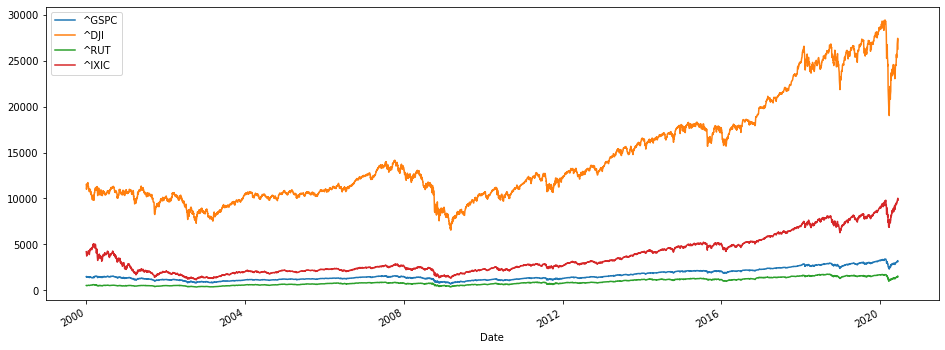

In [11]:
index_data.plot(figsize = (16,6))

### Importing 10 year maturity Data
 - Date will be from 2000-01-03 to 2020-06-11 
 - will check for missing data and replace with appropriate values 

In [12]:
index_data

,^GSPC,^DJI,^RUT,^IXIC
Date,,,,
2000-01-03,1469.250000,11501.849609,504.760010,4186.189941
2000-01-04,1455.219971,11349.750000,497.049988,4020.000000
2000-01-05,1399.420044,10989.370117,478.380005,3854.350098
2000-01-06,1402.109985,11113.370117,478.829987,3834.439941
2000-01-07,1403.449951,11247.059570,475.339996,3711.090088
...,...,...,...,...
2020-06-05,3163.840088,26836.800781,1460.180054,9703.540039
2020-06-08,3199.919922,27232.929688,1510.589966,9823.440430
2020-06-09,3213.320068,27447.369141,1533.030029,9867.190430


In [13]:
data = pd.read_csv("resources/10year_treasury.csv")

In [14]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [15]:
data.set_index('DATE', inplace=True)

In [16]:
data.replace(["."], np.nan, inplace = True)

In [17]:
data["DGS10"] = pd.to_numeric(data["DGS10"])

In [18]:
data

,DGS10
DATE,
2000-01-03,6.58
2000-01-04,6.49
2000-01-05,6.62
2000-01-06,6.57
2000-01-07,6.52
...,...
2020-06-05,0.91
2020-06-08,0.88
2020-06-09,0.84


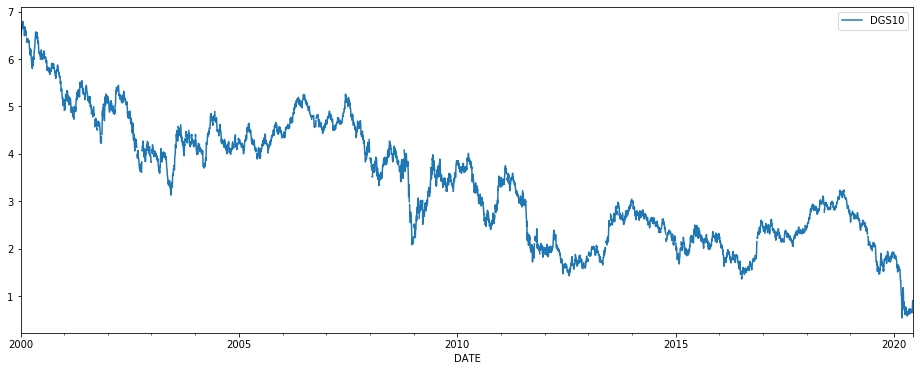

In [19]:
data.plot(figsize = (16,6))

### Concating Data
- Bringing the market data and 10 year maturity together
- We can see that there is a negative correlation betwee nthe markets and the 10 year constant rate

In [20]:
working_data = pd.concat([index_data.dropna(), data], axis=1)

In [21]:
working_data.corr()

,^GSPC,^DJI,^RUT,^IXIC,DGS10
^GSPC,1.000000,0.992026,0.961328,0.985083,-0.555849
^DJI,0.992026,1.000000,0.971867,0.972967,-0.596743
^RUT,0.961328,0.971867,1.000000,0.929796,-0.652811
^IXIC,0.985083,0.972967,0.929796,1.000000,-0.551473
DGS10,-0.555849,-0.596743,-0.652811,-0.551473,1.000000


### Daily Returns
- Volatility of the market and 10 year maturity rate
- The 10 year rate semes to have had volitility between -10 and 10% 
- where as the markets move around 5%+-

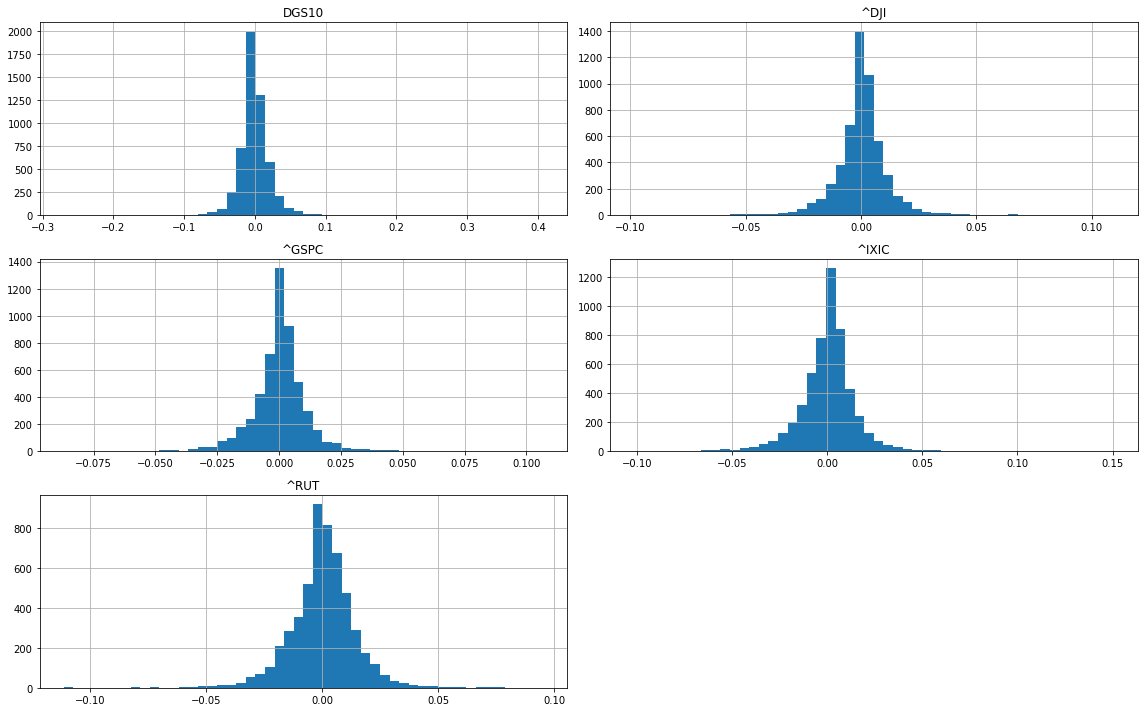

In [22]:
working_data.pct_change().hist(bins = 50, figsize = (16,10))
plt.tight_layout()

### Model Generation 
- Will create a Deep Neural Network that will aim to predict he 10 year maturity rate based on the movement of the markets
- We will need to check for missing data and drop the values for the model
- We can see that there is missing data colored in yellow 

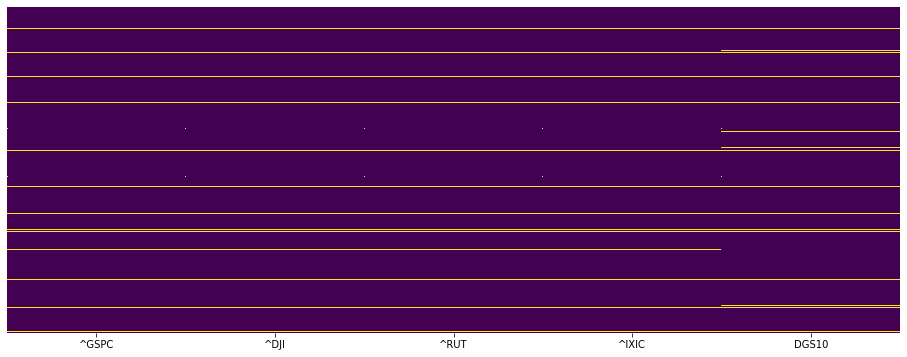

In [23]:
plt.figure(figsize=(16,6))
sns.heatmap(working_data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [24]:
working_data.dropna().isnull().sum()

^GSPC    0
^DJI     0
^RUT     0
^IXIC    0
DGS10    0
dtype: int64

In [25]:
X = working_data.dropna().drop("DGS10", axis=1).values
y = working_data.dropna()['DGS10'].values

### Training Testing and Splitting

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Scaling
- Training the data for a normal distribution

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scalar = MinMaxScaler()

In [30]:
X_train = scalar.fit_transform(X_train)

In [31]:
X_test = scalar.transform(X_test)

In [32]:
X_train.shape

(3574, 4)

In [33]:
X_test.shape

(1532, 4)

## Model Prepration 
- Will use a sequential model 
- Will use a early stopping callback to prevent over fitting

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
stop = EarlyStopping(monitor="val_loss", mode = "min", patience=30)

### Model Creation

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Model Architectire

In [37]:
model = Sequential()
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting model 

In [38]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=450, callbacks=[stop])

Train on 3574 samples, validate on 1532 samples
Epoch 1/450
3574/3574 [==============================] - 3s 798us/sample - loss: 12.0915 - val_loss: 11.1559
Epoch 2/450
3574/3574 [==============================] - 1s 162us/sample - loss: 3.9628 - val_loss: 0.9686
Epoch 3/450
3574/3574 [==============================] - 1s 162us/sample - loss: 0.7704 - val_loss: 0.7546
Epoch 4/450
3574/3574 [==============================] - 1s 164us/sample - loss: 0.6886 - val_loss: 0.6741
Epoch 5/450
3574/3574 [==============================] - 1s 163us/sample - loss: 0.6309 - val_loss: 0.6624
Epoch 6/450
3574/3574 [==============================] - 1s 166us/sample - loss: 0.5805 - val_loss: 0.5370
Epoch 7/450
3574/3574 [==============================] - 1s 175us/sample - loss: 0.4912 - val_loss: 0.4461
Epoch 8/450
3574/3574 [==============================] - 1s 165us/sample - loss: 0.3885 - val_loss: 0.3403
Epoch 9/450
3574/3574 [==============================] - 1s 165us/sample - loss: 0.2519 - val_

3574/3574 [==============================] - 1s 160us/sample - loss: 0.0905 - val_loss: 0.0897
Epoch 77/450
3574/3574 [==============================] - 1s 161us/sample - loss: 0.0892 - val_loss: 0.0971
Epoch 78/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0908 - val_loss: 0.0911
Epoch 79/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0875 - val_loss: 0.0800
Epoch 80/450
3574/3574 [==============================] - 1s 161us/sample - loss: 0.0869 - val_loss: 0.0916
Epoch 81/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0925 - val_loss: 0.0897
Epoch 82/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0891 - val_loss: 0.0838
Epoch 83/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0887 - val_loss: 0.0865
Epoch 84/450
3574/3574 [==============================] - 1s 158us/sample - loss: 0.1003 - val_loss: 0.1112
Epoch 85/450
3574/3574 [=================

3574/3574 [==============================] - 1s 160us/sample - loss: 0.0658 - val_loss: 0.0720
Epoch 152/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0729 - val_loss: 0.0662
Epoch 153/450
3574/3574 [==============================] - 1s 159us/sample - loss: 0.0613 - val_loss: 0.0629
Epoch 154/450
3574/3574 [==============================] - 1s 163us/sample - loss: 0.0669 - val_loss: 0.0664
Epoch 155/450
3574/3574 [==============================] - 1s 168us/sample - loss: 0.0707 - val_loss: 0.0666
Epoch 156/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0593 - val_loss: 0.0711
Epoch 157/450
3574/3574 [==============================] - 1s 161us/sample - loss: 0.0636 - val_loss: 0.0634
Epoch 158/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0673 - val_loss: 0.0630
Epoch 159/450
3574/3574 [==============================] - 1s 162us/sample - loss: 0.0639 - val_loss: 0.0872
Epoch 160/450
3574/3574 [========

3574/3574 [==============================] - 1s 161us/sample - loss: 0.0506 - val_loss: 0.0726
Epoch 227/450
3574/3574 [==============================] - 1s 163us/sample - loss: 0.0488 - val_loss: 0.0510
Epoch 228/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0496 - val_loss: 0.0588
Epoch 229/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0505 - val_loss: 0.0459
Epoch 230/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0522 - val_loss: 0.0488
Epoch 231/450
3574/3574 [==============================] - 1s 163us/sample - loss: 0.0525 - val_loss: 0.0498
Epoch 232/450
3574/3574 [==============================] - 1s 159us/sample - loss: 0.0499 - val_loss: 0.0496
Epoch 233/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0496 - val_loss: 0.0594
Epoch 234/450
3574/3574 [==============================] - 1s 161us/sample - loss: 0.0456 - val_loss: 0.0481
Epoch 235/450
3574/3574 [========

3574/3574 [==============================] - 1s 161us/sample - loss: 0.0428 - val_loss: 0.0418
Epoch 302/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0463 - val_loss: 0.0431
Epoch 303/450
3574/3574 [==============================] - 1s 159us/sample - loss: 0.0428 - val_loss: 0.0457
Epoch 304/450
3574/3574 [==============================] - 1s 160us/sample - loss: 0.0454 - val_loss: 0.0505


### Model Performnce
- Will take a look at the trainign performance of the model
- Model trained well and did not stop with our early stopping callback. There is still room for training here bur we will see how them model predicts

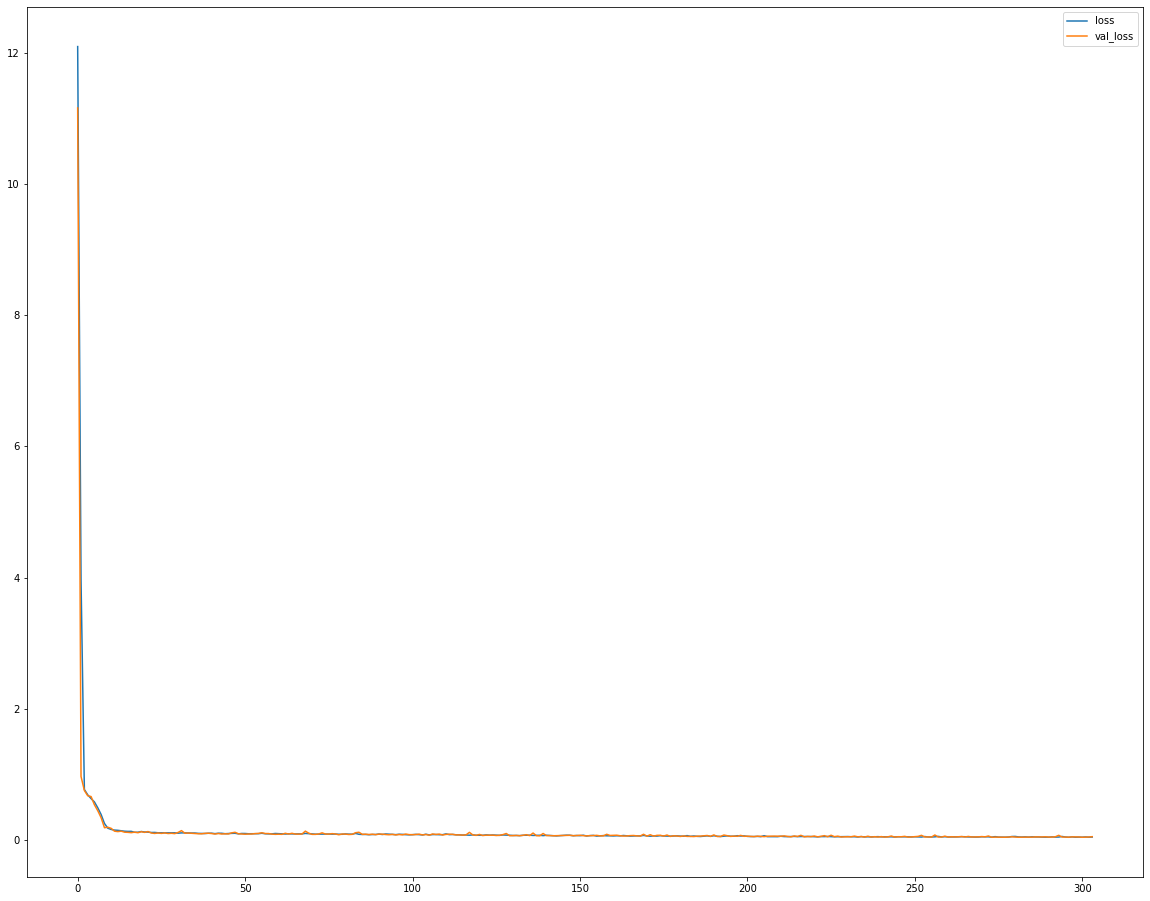

In [41]:
pd.DataFrame(model.history.history).plot(figsize = (20,16))
plt.savefig("resources/model_training_plot.jpg")

In [39]:
model.save("indexto_10year_yield_Deployed.h5")

In [40]:
pd.DataFrame(model.history.history).to_csv("resources/model_deployed_history.csv")

### Model Predictions

In [42]:
predictions = model.predict(X_test)

### Will take a look at the metrics 

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [44]:
mean_absolute_error(y_test, predictions)

0.1722995728892384

In [45]:
mean_squared_error(y_test,predictions)

0.05054592102327381

In [46]:
np.sqrt(mean_squared_error(y_test, predictions))

0.22482420026161287

In [47]:
explained_variance_score(y_test,predictions)

0.970760409723183

### Predictions on Random Data 

In [89]:
from random import randint
random_index = randint(1, len(working_data.dropna()))
random_day = working_data.dropna().drop(["DGS10"], axis = 1).iloc[random_index]

### Random Data Prepration 
- will need to scale and get the values for the data
- Random day will also need to reshape the new data 

In [90]:
X_train.shape

(3574, 4)

In [91]:
new_day = scalar.transform(random_day.values.reshape(1,4))

In [92]:
new_day

array([[0.2755664 , 0.25611734, 0.3319722 , 0.15378328]])

## Prediction on Random Data
- The 10 year rate is predicted below 

In [93]:
model.predict(new_day)

array([[4.7466507]], dtype=float32)

### Actual Value

In [94]:
working_data.iloc[random_index]

^GSPC     1304.250000
^DJI     11383.469727
^RUT       720.570007
^IXIC     2189.169922
DGS10        4.740000
Name: 2006-08-31 00:00:00, dtype: float64

In [95]:
working_data.iloc[random_index]["DGS10"]

4.74

### Lets check todays Prediction got  the 10 year constant Rate
- We will will drop the target which is the 10 Year constant Rate

In [55]:
week_data = pd.DataFrame()

In [56]:
for t in tickers:
    week_data[t] = web.DataReader(t, data_source= "yahoo", start = "2020-6-12")["Adj Close"]

In [57]:
week_data

,^GSPC,^DJI,^RUT,^IXIC
Date,,,,
2020-06-12,3041.310059,25605.539062,1387.680054,9588.809570
2020-06-15,3066.590088,25763.160156,1419.609985,9726.019531
2020-06-16,3124.739990,26289.980469,1452.260010,9895.870117
2020-06-17,3113.489990,26119.609375,1426.530029,9910.530273
2020-06-18,3115.340088,26080.099609,1427.329956,9943.049805
2020-06-19,3097.739990,25871.460938,1418.630005,9946.120117
2020-06-22,3117.860107,26024.960938,1433.530029,10056.480469
2020-06-23,3131.290039,26156.099609,1439.339966,10131.370117
2020-06-24,3050.330078,25445.939453,1389.739990,9909.169922


In [58]:
X_train.shape

(3574, 4)

In [59]:
todays_data = scalar.transform(week_data[-1:].values.reshape(1,4))

In [60]:
model.predict(todays_data)

array([[0.68280876]], dtype=float32)